In [ ]:
# Cropping train and test images according to bounding boxes in digitStruct.mat

import os
import h5py
from PIL import Image
from tqdm import tqdm  # voortgangsbalk


def load_digit_struct(mat_file):
    def _read_name(f, name_ref):
        return ''.join(chr(c[0]) for c in f[name_ref][:])

    def _read_attr_values(f, attr_ds):
        vals = []
        if attr_ds.shape[0] > 1:
            for i in range(attr_ds.shape[0]):
                vals.append(int(f[attr_ds[i][0]][()][0][0]))
        else:
            vals.append(int(attr_ds[()][0][0]))
        return vals

    out = []
    with h5py.File(mat_file, "r") as f:
        ds = f["digitStruct"]
        names = ds["name"]
        bboxes = ds["bbox"]
        n = len(names)
        for i in range(n):
            name = _read_name(f, names[i][0])
            bbox_group = f[bboxes[i][0]]
            bbox = {}
            for key in ["label", "left", "top", "width", "height"]:
                bbox[key] = _read_attr_values(f, bbox_group[key])
            out.append({"name": name, "bbox": bbox})
    return out


def preprocess_split(split_root, out_root):
    os.makedirs(out_root, exist_ok=True)
    mat_file = os.path.join(split_root, "digitStruct.mat")
    entries = load_digit_struct(mat_file)

    for entry in tqdm(entries, desc=f"Cropping {os.path.basename(split_root)}"):
        img_path = os.path.join(split_root, entry["name"])
        img = Image.open(img_path).convert("RGB")

        for idx, (l, left, top, w, h) in enumerate(
            zip(entry["bbox"]["label"], entry["bbox"]["left"], entry["bbox"]["top"],
                entry["bbox"]["width"], entry["bbox"]["height"])
        ):
            label = 0 if l == 10 else l  # in SVHN: label=10 betekent "0"
            x1, y1, x2, y2 = int(left), int(top), int(left+w), int(top+h)
            crop = img.crop((x1, y1, x2, y2))

            label_dir = os.path.join(out_root, str(label))
            os.makedirs(label_dir, exist_ok=True)

            # unieker bestandsnaam: originele naam + index
            base_name = os.path.splitext(entry["name"])[0]
            crop_path = os.path.join(label_dir, f"{base_name}_{idx}.png")
            crop.save(crop_path)


# Crop train and test images
SVHN_ROOT = ""
OUT_ROOT = "SVHN_crops"

preprocess_split(os.path.join(SVHN_ROOT, "train"), os.path.join(OUT_ROOT, "train"))

preprocess_split(os.path.join(SVHN_ROOT, "test"), os.path.join(OUT_ROOT, "test"))



In [ ]:
# ========================
# SVHN single-digit training script
# images have been cropped to single digits
# using the bounding boxes provided in the dataset
# and saved in  SVHN_crops/train and SVHN_crops/test
# ========================
import time, random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder


# Set seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(42)

#  Paths & Device 
device = "cpu"
print(f'Using device: {device}')

train_dir = "SVHN_crops/train"
test_dir  = "SVHN_crops/test"

#  Transforms 

MEAN = [0.4377, 0.4438, 0.4728]
STD  = [0.1980, 0.2010, 0.1970]

train_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds_0 = ImageFolder(root=train_dir, transform=train_tf)
test_ds_0  = ImageFolder(root=test_dir, transform=val_tf)


#  Model  
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training and evalutation loops 
def accuracy(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == labels).float().sum().item()
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == labels).float().sum().item()
        n += bs
    return total_loss / n, total_acc / n

# Data & Training setup 

BATCH_SIZE = 32
VAL_SPLIT = 0.1
EPOCHS = 15
LR = 1e-3
NUM_WORKERS = 0

full_train_ds = train_ds_0
n_total = len(full_train_ds)
n_val = int(VAL_SPLIT * n_total)
n_train = n_total - n_val
train_ds, val_ds = random_split(full_train_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds_0, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}"
      + (f", Test samples: {len(test_loader.dataset)}" if test_loader else ""))


#  Model, loss, optimizer
model = SmallCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

best_val_acc = 0.0
best_path = "svhn_cnn_best.pth"

# Train 
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_acc)

    dt = time.time() - t0
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | {dt:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"New best val acc: {best_val_acc:.4f} -> saved to {best_path}")

# Test 
if test_loader:
    model.load_state_dict(torch.load(best_path, map_location=device))
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"TEST  loss {test_loss:.4f}  acc {test_acc:.4f}")
else:
    print("No test set available")


Using device: cpu
Train samples: 36843, Val samples: 4093, Test samples: 26032


c:\Users\f_voe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[01/15] train loss 1.6104 acc 0.4671 | val loss 1.3518 acc 0.5314 | 43.7s
  ✓ New best val acc: 0.5314 -> saved to svhn_cnn_best.pth
[02/15] train loss 0.9667 acc 0.7175 | val loss 0.8044 acc 0.7652 | 29.4s
  ✓ New best val acc: 0.7652 -> saved to svhn_cnn_best.pth
[03/15] train loss 0.6927 acc 0.7994 | val loss 0.6202 acc 0.8199 | 28.6s
  ✓ New best val acc: 0.8199 -> saved to svhn_cnn_best.pth
[04/15] train loss 0.5714 acc 0.8333 | val loss 0.4957 acc 0.8537 | 28.7s
  ✓ New best val acc: 0.8537 -> saved to svhn_cnn_best.pth
[05/15] train loss 0.5076 acc 0.8494 | val loss 0.4807 acc 0.8480 | 28.5s
[06/15] train loss 0.4668 acc 0.8598 | val loss 0.4427 acc 0.8664 | 28.3s
  ✓ New best val acc: 0.8664 -> saved to svhn_cnn_best.pth
[07/15] train loss 0.4347 acc 0.8705 | val loss 0.4608 acc 0.8515 | 28.4s
[08/15] train loss 0.4109 acc 0.8759 | val loss 0.3929 acc 0.8776 | 29.4s
  ✓ New best val acc: 0.8776 -> saved to svhn_cnn_best.pth
[09/15] train loss 0.3954 acc 0.8815 | val loss 0.3922

In [ ]:
# Continue training single-digit recognition (continue from the script above, saved parameters in svhn_cnn_best.pth)

# ========================
# SVHN single-digit training script
# ========================
import os, math, time, random
import h5py
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder


# Setting seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(42)


device = "cpu"
print(f'Using device: {device}')

train_dir = "SVHN_crops/train"
test_dir  = "SVHN_crops/test"

# Transforms to tensors

MEAN = [0.4377, 0.4438, 0.4728]
STD  = [0.1980, 0.2010, 0.1970]

train_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_ds_0 = ImageFolder(root=train_dir, transform=train_tf)
test_ds_0  = ImageFolder(root=test_dir, transform=val_tf)


# Model  
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training and evaluation loops 
def accuracy(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == labels).float().sum().item()
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)

        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == labels).float().sum().item()
        n += bs
    return total_loss / n, total_acc / n

# Data & Training setup 
     
BATCH_SIZE = 32
VAL_SPLIT = 0.1
START_EPOCH = 15   
EPOCHS = 15  
LR = 1e-3
NUM_WORKERS = 0

full_train_ds = train_ds_0
n_total = len(full_train_ds)
n_val = int(VAL_SPLIT * n_total)
n_train = n_total - n_val
train_ds, val_ds = random_split(full_train_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds_0, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}"
      + (f", Test samples: {len(test_loader.dataset)}" if test_loader else ""))



# Define model, loss, optimize 
model = SmallCNN(num_classes=10)
model.load_state_dict(torch.load("svhn_cnn_best.pth", map_location=device))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

best_val_acc = 0.0
best_path = "svhn_cnn_best.pth"

# Train 
for epoch in range(START_EPOCH+1, START_EPOCH + EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_acc)

    dt = time.time() - t0
    print(f"[{epoch:02d}/{START_EPOCH + EPOCHS}] "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | {dt:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"  ✓ New best val acc: {best_val_acc:.4f} -> saved to {best_path}")

# Test 
if test_loader:
    model.load_state_dict(torch.load(best_path, map_location=device))
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"TEST  loss {test_loss:.4f}  acc {test_acc:.4f}")
else:
    print("No test set available")


Using device: cpu
Train samples: 36843, Val samples: 4093, Test samples: 26032


c:\Users\f_voe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[16/30] train loss 0.3381 acc 0.8980 | val loss 0.3715 acc 0.8859 | 44.3s
  ✓ New best val acc: 0.8859 -> saved to svhn_cnn_best.pth
[17/30] train loss 0.3300 acc 0.9012 | val loss 0.3411 acc 0.8974 | 29.2s
  ✓ New best val acc: 0.8974 -> saved to svhn_cnn_best.pth
[18/30] train loss 0.3228 acc 0.9014 | val loss 0.3355 acc 0.8974 | 29.3s
[19/30] train loss 0.3172 acc 0.9037 | val loss 0.3236 acc 0.9023 | 29.3s
  ✓ New best val acc: 0.9023 -> saved to svhn_cnn_best.pth
[20/30] train loss 0.3074 acc 0.9071 | val loss 0.3331 acc 0.8949 | 29.4s
[21/30] train loss 0.3003 acc 0.9103 | val loss 0.3428 acc 0.9001 | 29.2s
[22/30] train loss 0.2952 acc 0.9118 | val loss 0.3626 acc 0.8876 | 29.0s
[23/30] train loss 0.2593 acc 0.9235 | val loss 0.3025 acc 0.9062 | 29.0s
  ✓ New best val acc: 0.9062 -> saved to svhn_cnn_best.pth
[24/30] train loss 0.2523 acc 0.9248 | val loss 0.3059 acc 0.9069 | 30.8s
  ✓ New best val acc: 0.9069 -> saved to svhn_cnn_best.pth
[25/30] train loss 0.2487 acc 0.9258 | 

c:\Users\f_voe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\f_voe\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


start epoch  1
Epoch 1, Loss: 0.2282


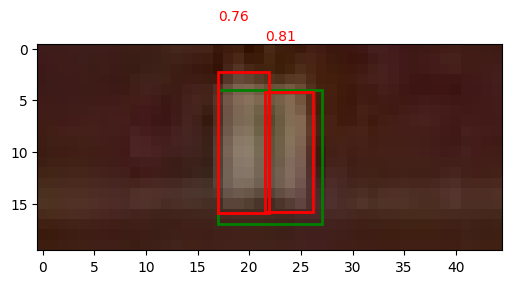

start epoch  2
Epoch 2, Loss: 0.2134


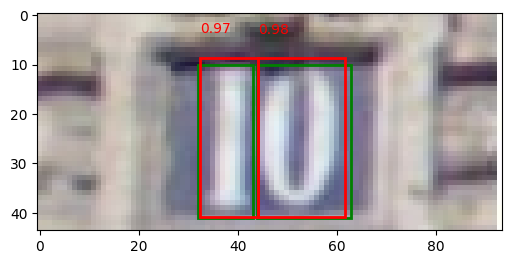

start epoch  3
Epoch 3, Loss: 0.2017


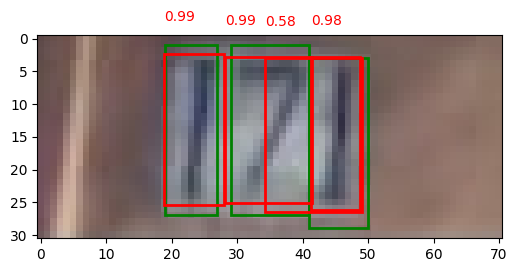

start epoch  4
Epoch 4, Loss: 0.1955


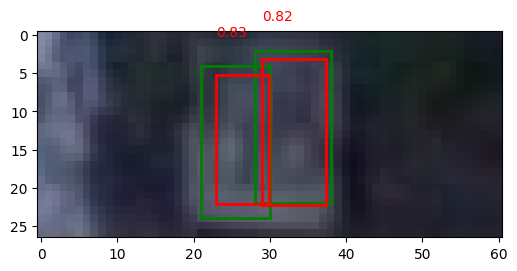

start epoch  5
Epoch 5, Loss: 0.1890


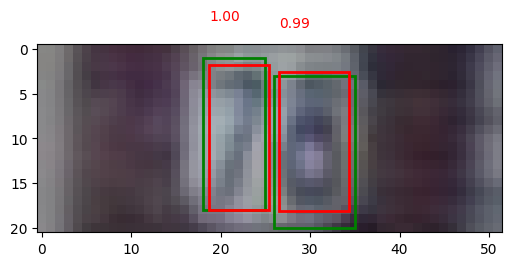

In [ ]:


# ========================
# make bounding boxed around digits in SVHN images
# ========================

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as T
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from PIL import Image

class SVHNDataset(Dataset):
    def __init__(self, root, mat_file, transforms=None, only_boxes=True):
        self.root = root
        self.transforms = transforms
        self.only_boxes = only_boxes

        self.f = h5py.File(mat_file, 'r')
        self.digitStruct = self.f['digitStruct']
        self.names = self.digitStruct['name']
        self.bboxes = self.digitStruct['bbox']
        self.length = self.names.shape[0]

    def __len__(self):
        return self.length

    def __del__(self):
        try:
            self.f.close()
        except Exception:
            pass

    def _get_name(self, name_ref):
        name_ds = self.f[name_ref]
        return "".join(chr(c[0]) for c in name_ds[()])

    def _get_bbox(self, bbox_ref):
        bbox_grp = self.f[bbox_ref]

        def extract(field):
            ds = bbox_grp[field]
            if ds.shape[0] == 1:
                return [ds[()][0][0]]
            else:
                return [self.f[ds[i][0]][()][0][0] for i in range(ds.shape[0])]

        left   = extract("left")
        top    = extract("top")
        width  = extract("width")
        height = extract("height")
        label  = extract("label")
        return left, top, width, height, label

   
    def __getitem__(self, idx):
       
        name_ref = self.names[idx][0]
        bbox_ref = self.bboxes[idx][0]

        img_name = self._get_name(name_ref)
        left, top, width, height, label = self._get_bbox(bbox_ref)

        boxes, labels = [], []
        for l, t, w, h, lbl in zip(left, top, width, height, label):
            boxes.append([float(l), float(t), float(l + w), float(t + h)])
            if self.only_boxes:
                labels.append(1)
            else:
                lbl = int(lbl)
                labels.append(0 if lbl == 10 else lbl)  

        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }
        return img, target


def get_bounding_boxes(num_classes=2, pretrained=False):  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


def show_predictions(model, dataset, device, idx=0, score_thresh=0.5):
    model.eval()
    img, target = dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)

    # Zet terug naar numpy voor tekenen
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_np)

    # Ground-truth in groen
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.tolist()
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             fill=False, color="green", linewidth=2)
        ax.add_patch(rect)

    # Predictions in rood
    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]

    for box, score in zip(boxes, scores):
        if score < score_thresh:
            continue
        x1, y1, x2, y2 = box.tolist()
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                             fill=False, color="red", linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"{score:.2f}", color="red")

    plt.show()


# Dataset
dataset = SVHNDataset(
    root="train/",
    mat_file="train/digitStruct.mat",
    transforms=T.ToTensor()
)

dataset_small = Subset(dataset, range(2000, 4000))  

data_loader = DataLoader(dataset_small, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Model
device = "cpu"
model = get_bounding_boxes(num_classes=2, pretrained=False)
model.load_state_dict(torch.load("svhn_detector.pth", map_location=device))
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 5
epoch_loss = 0
for epoch in range(num_epochs):
    print("start epoch ", epoch+1)
    model.train()
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    
    epoch_loss /= len(data_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    show_predictions(model, dataset, device, idx=np.random.randint(len(dataset_small)), score_thresh=0.5)
    
torch.save(model.state_dict(), "svhn_detector2.pth")

In [3]:
# ========================
# compose models and predict house number: detection bounding boxes, crop and classification
# ========================
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from PIL import Image, ImageDraw
import numpy as np
import torch.nn as nn
import os

# ----------------------
# Helper to draw boxes on picture
# ----------------------

def draw_boxes(image, results):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    for r in results:
        x1, y1, x2, y2 = r["box"]
        digit = r["digit"]
        score = r["score"]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), f"{digit} ({score:.2f})", fill="red")
    return image


# ----------------------
# Load detector, trained parameters loaded from file: svhn_detector.pth
# ----------------------
def get_bounding_boxes(num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = "cpu"

detector = get_bounding_boxes(num_classes=2)
detector.load_state_dict(torch.load("svhn_detector.pth", map_location=device))
detector.to(device)
detector.eval()

# ----------------------
# Load Classifier, trained parameters loaded from file: svhn_cnn_best.pth
# ----------------------
class SVHNClassifier(torch.nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


classifier = SVHNClassifier()
classifier.load_state_dict(torch.load("svhn_cnn_best.pth", map_location=device))
classifier.to(device)
classifier.eval()

# ----------------------
# Transform to tensor and normalize
# ----------------------
detector_transform = T.ToTensor()

MEAN = [0.4377, 0.4438, 0.4728]
STD  = [0.1980, 0.2010, 0.1970]
classifier_transform = T.Compose([
    T.Resize((32, 32)),  
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])


# ----------------------
# Pipeline
# ----------------------
def recognize_number(image_path, score_thresh=0.5):
    
    image = Image.open(image_path).convert("RGB")
    img_tensor = detector_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = detector(img_tensor)

    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]

    results = []
    for box, score in zip(boxes, scores):
        if score < score_thresh:
            continue

        x1, y1, x2, y2 = map(int, box.tolist())
        cropped = image.crop((x1, y1, x2, y2))

        crop_tensor = classifier_transform(cropped).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = classifier(crop_tensor).argmax(dim=1).item()

        results.append({"digit": pred, "box": (x1, y1, x2, y2), "score": float(score)})


    results = sorted(results, key=lambda r: r["box"][0])       # Sort left to right
    number = "".join(str(r["digit"]) for r in results)  # Join digits as string
    
    return number, results



image_to_test = "extra/340.png"

if os.path.exists(image_to_test):
    number, results = recognize_number(image_to_test, score_thresh=0.6)
    print("Predicted house number:", number)
else:
    print(f"File not found: {image_to_test}")

img_with_boxes = draw_boxes(Image.open(image_to_test).convert("RGB"), results)
img_with_boxes.show()



Predicted house number: 53
